This notebook runs the most simple simulation with a tabular Q method to control the sensor agent

In [138]:
from agent import CircleAgent, OptimalAgent, SensorQAgent, SensorDQAgent
from gridworld import GridWorld

from collections import deque
from random  import choice, random
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch


In [139]:
base_config = {
        'agent': SensorQAgent,
        'ds': tuple,
        'alpha': 0.1,
        'gamma': 0.9,
        'epsilon': 1,
        'epsilon_decay': 0.99,
        'epsilon_min': 0.1,
        'trajectory_length': 4, # 3 positions of size 2
        'coverage_window': 8,
        'exact_position': False,
        'w1': 1,
        'w2': 0.1,
        'n_episodes': 10000,
        'n_test_episodes': 1,
        'max_episode_length': 21,
        'start': (0,0),
        'goal': (0,0),
        'wait_time': 1,
        'grid': [['-' for j in range(5)] for i in range(5)],
        'name': '',
        'var': ''
    }
base_config['epsilon_decay'] = base_config['epsilon_min'] ** (1/base_config['n_episodes'])

experimental_config =[]
cfg_values = [.1,0.3,0.5]
for i in cfg_values:
    mod = deepcopy(base_config)
    mod['w2'] = i
    mod['name'] = f"w2={i}"
    mod['var'] = 'w2'    
    experimental_config.append(mod)

if experimental_config == []:
    experimental_config.append(base_config)

In [140]:
def generate_training_data(env, user, n_episodes, ep_length):
    data = []
    
    for i in range(n_episodes):
        trajectory = [env.start]
        env.reset()
        user.reset()
        for j in range(ep_length):
            action = user.policy()
            newX = env.agent_location[0] + action[0]
            newY = env.agent_location[1] + action[1]
            trajectory.append((newX,newY))
            env.move_agent(newX, newY)
            if env.is_terminal():
                break
        data.append(trajectory)

    return data

In [141]:
def simple_moving_average(data, window_size):
    if len(data) < window_size:
        raise ValueError("Data size must be greater than or equal to the window size.")

    # Use the 'valid' mode to ensure that output size is the same as input size
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')



In [142]:
def train(cfgs):
    results = []
    for cfg in cfgs:
        print(cfg['name'])
        env = GridWorld(cfg['start'], cfg['goal'], cfg['grid'])
        user = CircleAgent(env,cfg['wait_time']) 
        train_data = generate_training_data(env, user, cfg['n_episodes'], cfg['max_episode_length'])
        oagent = OptimalAgent() 
        agent = cfg['agent'](cfg)
        train_ep_rewards = []
        r_0s = []
        r_1s = []
        for episode in tqdm(train_data):
            trajectory = deque(maxlen=cfg['trajectory_length'])
            coverage_window = deque(maxlen=cfg['coverage_window'])
            covered_states = deque(maxlen=cfg['coverage_window'])
            sensor_usage = deque(maxlen=cfg['coverage_window'])
            sensed = set()
            visited = set()
            activation_count = 0
            ep_reward = 0
            r_0 = 0
            r_1 = 0
            for i in range(cfg['trajectory_length']):
                trajectory.append(0)
                trajectory.append(0)
            for t,position in enumerate(episode):
                visited.add(position)
                s = cfg['ds'](trajectory)
                action = agent.policy(s)

                if action[1]: #give agent knowledge of position if sensor was activated
                    sensed.add(position)
                    sensor_usage.append(1)
                    if position not in covered_states:
                        coverage_window.append(1)
                    else:
                        coverage_window.append(0)
                    covered_states.append(position)
                    coverage_window.append(1)
                    activation_count +=1
                    trajectory.append(position[0])
                    trajectory.append(position[1])
                elif cfg['exact_position']:
                    trajectory.append(position[0])
                    trajectory.append(position[1])
                    coverage_window.append(0)
                else:
                    trajectory.append(-1)
                    trajectory.append(-1)
                    coverage_window.append(0)
                    sensor_usage.append(0)

                r = (cfg['w1'] * sum(coverage_window)/len(coverage_window) - cfg['w2']* action[1])
                r_0 += r if action[0] else 0
                r_1 += r if action[1] else 0
                s_ = cfg['ds'](trajectory)
                ep_reward += r
                agent.update(s, action[1], r, s_, position != env.goal)
            r_0s.append(r_0)
            r_1s.append(r_1)
            train_ep_rewards.append(ep_reward)

            
        # test
        test_data = generate_training_data(env, user, cfg['n_test_episodes'], cfg['max_episode_length'])
        test_ep_reward = []
        sensor_usage = []
        for episode in (test_data):
            trajectory = deque(maxlen=cfg['trajectory_length'])
            su =0
            sensed = set()
            visited = set()
            os = set()
            oreward = 0
            ep_reward = 0
            for i in range(cfg['trajectory_length']):
                trajectory.append(0)
                trajectory.append(0)

            for t,position in enumerate(episode):
                visited.add(position)
                s = tuple(trajectory)
                action = agent.max_action(s)
                oa = oagent.max_action(position)
                if oa[1]:
                    os.add(position)
                if action[1]: #give agent knowledge of position if sensor was activated
                    sensed.add(position)
                    trajectory.append(position[0])
                    trajectory.append(position[1])
                    su+=1
                elif cfg['exact_position']:
                    trajectory.append(position[0])
                    trajectory.append(position[1])
                else:
                    trajectory.append(-1)
                    trajectory.append(-1)

                s_ = tuple(trajectory)
                ep_reward += (cfg['w1'] * len(sensed)/len(visited) - cfg['w2']*action[1])
                oreward +=(cfg['w1'] * len(os)/len(visited) - cfg['w2']*oa[1])

                # print(oreward, ep_reward)
            test_ep_reward.append(ep_reward)
            sensor_usage.append(su/len(episode))

        results.append({
            'train_ep_rewards': train_ep_rewards,
            'r_0s': r_0s,
            'r_1s': r_1s,
            'test_ep_reward': test_ep_reward,
            'sensor_usage': sensor_usage,
            'name': cfg['name'],
            'agent_q_values': agent.q_values,
            'oreward': oreward,
            'var': cfg['var'],
        })
    return results

In [143]:
tabular_results = train(experimental_config)

w2=0.1


100%|██████████| 10000/10000 [00:03<00:00, 2889.57it/s]


w2=0.3


100%|██████████| 10000/10000 [00:03<00:00, 3295.43it/s]


w2=0.5


100%|██████████| 10000/10000 [00:03<00:00, 3258.67it/s]


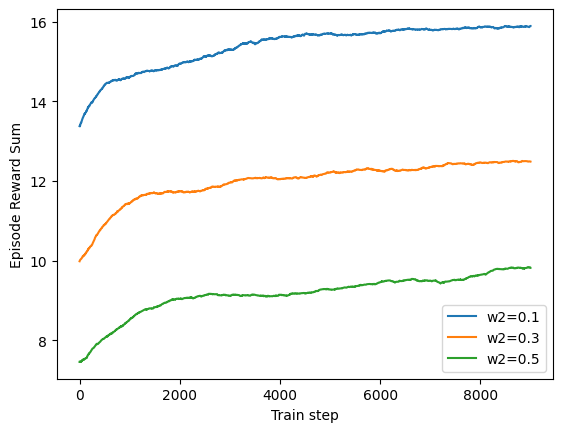

In [144]:
for result in tabular_results:
    plt.plot(simple_moving_average(result['train_ep_rewards'],int(len(result['train_ep_rewards'])/10)), label=result['name'])
    plt.legend()
    plt.xlabel('Train step')
    plt.ylabel(f'Episode Reward Sum')


Text(0, 0.5, 'Episode Reward Sum')

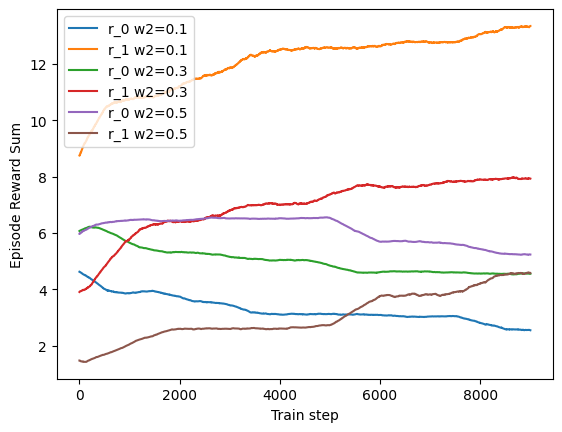

In [145]:
for result in tabular_results:
    plt.plot(simple_moving_average(result['r_0s'],int(len(result['r_0s'])/10)), label=f"r_0 {result['name']}")
    plt.plot(simple_moving_average(result['r_1s'],int(len(result['r_1s'])/10)), label=f"r_1 {result['name']}")
plt.legend()
plt.xlabel('Train step')
plt.ylabel(f'Episode Reward Sum')

Name: w2=0.1 Episode reward: [18.2] sensor usage: [0.9]
Name: w2=0.3 Episode reward: [13.314035964035963] sensor usage: [0.75]
Name: w2=0.5 Episode reward: [12.49214951714952] sensor usage: [0.65]


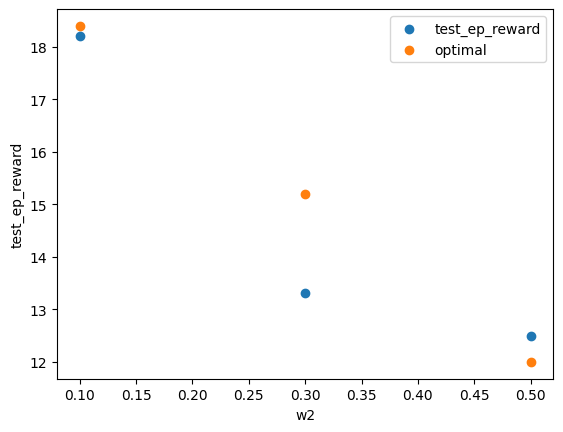

In [146]:
result = [i['test_ep_reward'][0] for i in tabular_results]
optimal_result = [i['oreward'] for i in tabular_results]
plt.scatter(cfg_values,result, label='test_ep_reward')
plt.scatter(cfg_values,optimal_result, label='unique_states')
# plt.plot(result)
plt.xlabel(tabular_results[0]['var'])
plt.ylabel('test_ep_reward')
plt.legend()
for result in tabular_results:
    print(f"Name: {result['name']} Episode reward: {result['test_ep_reward']} sensor usage: {result['sensor_usage']}")

In [147]:
for result in tabular_results:
    qmap = np.zeros(shape=(5,5))
    print(f"Name: {result['name']}")
    
    for k,v in result['agent_q_values'].items():
        if -1 not in k:
            qmap[k[3]][k[2]] = min(int(100*(v[1]-v[0]))/100, qmap[k[3]][k[2]]) if qmap[k[3]][k[2]] != 0 else int(100*(v[1]-v[0]))/100
    print(qmap)


Name: w2=0.1
[[ 0.73  0.03 -0.43  1.53 -1.11]
 [ 0.    0.    0.    0.   -0.81]
 [ 0.    0.    0.    0.   -0.49]
 [ 0.02  0.    0.    0.   -0.42]
 [ 0.13  0.32  0.   -0.15 -3.84]]
Name: w2=0.3
[[-0.18  0.04 -1.84 -2.02 -2.75]
 [ 0.    0.    0.    0.    2.64]
 [ 0.    0.    0.    0.    0.49]
 [-0.17  0.    0.    0.    1.68]
 [-0.69  1.95 -0.37 -0.12 -0.23]]
Name: w2=0.5
[[ 0.1   0.02 -0.53  2.27 -2.49]
 [ 0.    0.    0.    0.    1.42]
 [ 0.    0.    0.    0.   -0.65]
 [-0.24  0.    0.    0.   -2.67]
 [-1.51 -0.33 -0.4   0.07 -0.57]]
